In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
X = pd.read_csv("train.csv")
X.head()

,Unnamed: 0,X,Y,Depth,Thickness_of_Res,AI_over_Res,Curvature_on_Top_Res,Top_Res_depth,Res_Prob
0,1,740838,7234410,-0.994578,-195.2843,-10951.02,-0.000245,-5321.508,0.994578
1,2,740753,7238110,-0.989235,-215.9725,-10961.20,-0.000292,-5314.941,0.989235
2,3,741363,7231260,-0.997361,-300.0263,-10715.46,-0.001192,-5328.961,0.997361
3,4,751175,7238490,-0.986831,-168.5188,-10844.91,-0.000506,-5334.395,0.986831
4,5,737119,7229380,-0.947000,-175.4859,-10792.41,-0.001147,-5383.519,0.947000


In [3]:
X.columns

Index(['Unnamed: 0', 'X', 'Y', 'Depth', 'Thickness_of_Res', 'AI_over_Res',
       'Curvature_on_Top_Res', 'Top_Res_depth', 'Res_Prob'],
      dtype='object')

In [4]:
X.drop(['Unnamed: 0', 'X', 'Y', 'Depth'], axis=1, inplace=True)
X.head()

,Thickness_of_Res,AI_over_Res,Curvature_on_Top_Res,Top_Res_depth,Res_Prob
0,-195.2843,-10951.02,-0.000245,-5321.508,0.994578
1,-215.9725,-10961.20,-0.000292,-5314.941,0.989235
2,-300.0263,-10715.46,-0.001192,-5328.961,0.997361
3,-168.5188,-10844.91,-0.000506,-5334.395,0.986831
4,-175.4859,-10792.41,-0.001147,-5383.519,0.947000


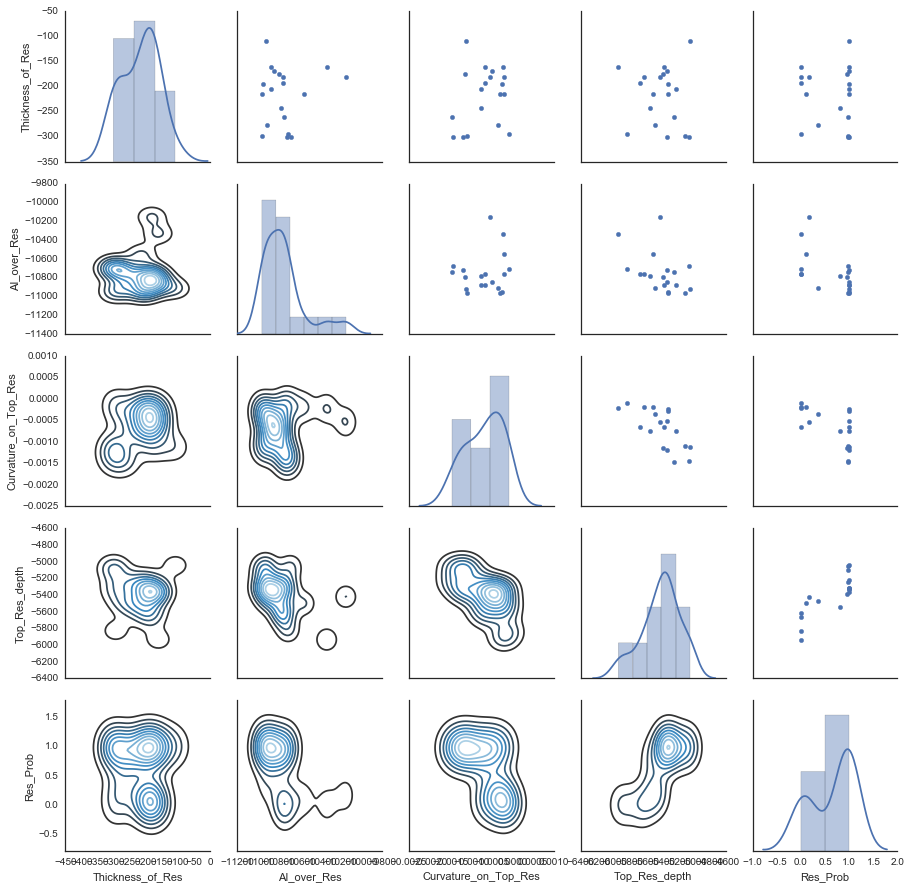

In [5]:
sns.set(style="white")

g = sns.PairGrid(X, diag_sharey=False);
g.map_lower(sns.kdeplot, cmap="Blues_d");
g.map_upper(plt.scatter);
g.map_diag(sns.distplot);
sns.plt.show()

In [6]:
y = X.pop("Res_Prob")

In [7]:
X.columns

Index(['Thickness_of_Res', 'AI_over_Res', 'Curvature_on_Top_Res',
       'Top_Res_depth'],
      dtype='object')

In [8]:
# logtransform AI
#X["AI_over_Res"].hist()
#X["AI_over_Res"] = np.log1p(-1*X["AI_over_Res"])

In [9]:
# standardizing features
scaler = StandardScaler()
features = X[['Thickness_of_Res', 'AI_over_Res', 'Curvature_on_Top_Res','Top_Res_depth']]
features = scaler.fit_transform(features.values)
Xs = pd.DataFrame(features,columns= ['Thickness_of_Res', 'AI_over_Res', 'Curvature_on_Top_Res','Top_Res_depth'])
Xs.head()

,Thickness_of_Res,AI_over_Res,Curvature_on_Top_Res,Top_Res_depth
0,0.406408,-0.969016,1.005959,0.357531
1,0.033131,-1.018525,0.899742,0.385669
2,-1.483453,0.176608,-1.171283,0.325596
3,0.889338,-0.452960,0.406516,0.302312
4,0.763631,-0.197631,-1.067550,0.091826


In [47]:
poly = PolynomialFeatures(1)
poly_features = poly.fit_transform(Xs)
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(Xs.columns,p) for p in poly.powers_]]
Xp = pd.DataFrame(poly_features, columns = target_feature_names)
Xp.head()

,,Thickness_of_Res^1,AI_over_Res^1,Curvature_on_Top_Res^1,Top_Res_depth^1
0,1.0,0.406408,-0.969016,1.005959,0.357531
1,1.0,0.033131,-1.018525,0.899742,0.385669
2,1.0,-1.483453,0.176608,-1.171283,0.325596
3,1.0,0.889338,-0.452960,0.406516,0.302312
4,1.0,0.763631,-0.197631,-1.067550,0.091826


In [48]:
#reg = RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75],  normalize=True, scoring="mean_squared_error", cv=5)
reg = RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75],  normalize=False, scoring='mean_squared_error', cv=5)
reg.fit(Xp,y)
reg.alpha_

5

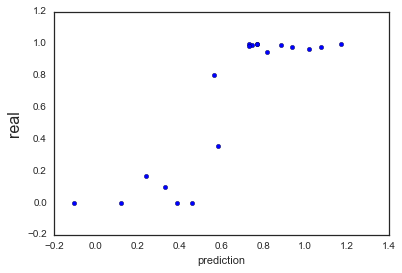

In [49]:
ridgecv_df = pd.DataFrame({'prediction':reg.predict(Xp),'real':y})
plt.xlabel('prediction')
plt.ylabel('real', fontsize=16)
plt.scatter(ridgecv_df.prediction, ridgecv_df.real)

In [50]:
reg.coef_

array([ 0.        ,  0.0216612 , -0.12800397, -0.10632767,  0.17703195])

In [51]:
reg.intercept_

0.64468715789473674

In [52]:
scaler.scale_

array([  5.54231251e+01,   2.05617183e+02,   4.34770146e-04,
         2.33382939e+02])

In [59]:
# create final formula
# scaling
formula = ['({}-{})'.format(pair[0],pair[1]) for pair in list(zip(X.columns,scaler.mean_))]
formula = ['{}/{}'.format(pair[0],pair[1]) for pair in list(zip(formula,scaler.scale_))]

# coeficients from regression
formula = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(formula,p) for p in poly.powers_]]
formula = ['{}*{}'.format(pair[0],pair[1]) for pair in list(zip(reg.coef_,formula)) if pair[0]!=0]
formula = '+'.join(formula)
formula.replace('--','+')
#formula.replace('-+','-')
#formula.replace('+-','-')
formula

'0.02166120465305411*(Thickness_of_Res--217.8087105263158)/55.42312509858654^1+-0.12800397053639026*(AI_over_Res--10751.773684210526)/205.61718308829012^1+-0.10632766635804354*(Curvature_on_Top_Res--0.0006828410526315789)/0.00043477014604688396^1+0.17703195354714868*(Top_Res_depth--5404.94952631579)/233.38293861385569^1'